## SARIMAで時系列予測を行う

In [1]:
%load_ext lab_black

In [2]:
# ライブラリーのインポート
import warnings

warnings.filterwarnings("ignore")

import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import statsmodels.api as sm
from plotly import tools
from plotly.graph_objs import Bar, Figure, Layout, Scatter
from plotly.offline import init_notebook_mode, iplot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

init_notebook_mode(connected=True)
save_image = None  # 'png' if save image

#### データの準備

In [3]:
# https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html
df = pd.read_csv("../../data/AirPassengers.csv")

# float型に変換
df["#Passengers"] = df["#Passengers"].astype("float64")
df = df.rename(columns={"#Passengers": "Passengers"})

# datetime型にしてインデックスにする
df.Month = pd.to_datetime(df.Month)
df = df.set_index("Month")

# データの中身を確認
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [4]:
df.dtypes

Passengers    float64
dtype: object

#### 時系列データの可視化

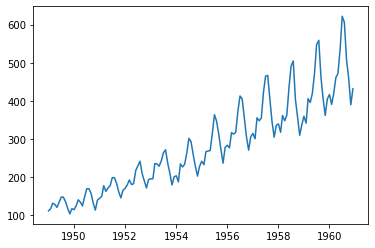

In [5]:
plt.plot(df.Passengers)
plt.show()

#### コレログラム

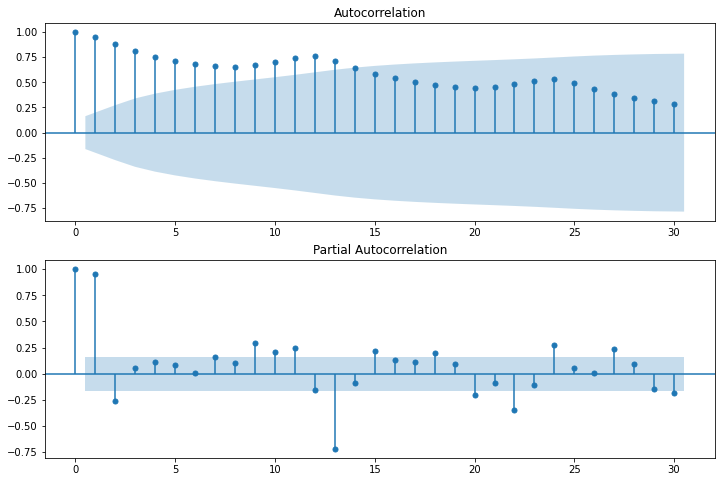

In [6]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.Passengers, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.Passengers, lags=30, ax=ax2)

#### 定常性の確認

* [adfuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) を用いて、Dickey-Fuller 検定を行う
* Passengers: p-value > 0.1なので有意水準10%で帰無仮説（定常性を満たす）は棄却されず、定常ではない

In [7]:
res = sm.tsa.stattools.adfuller(df.Passengers)
print("p-value = {:.4}".format(res[1]))

p-value = 0.9919


#### 成分分解

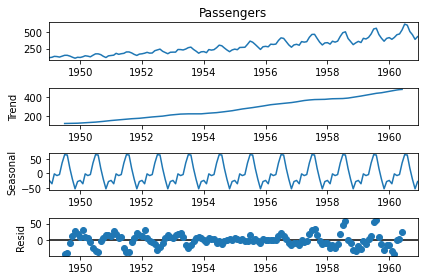

In [8]:
res = sm.tsa.seasonal_decompose(df["Passengers"])
fig = res.plot()

#### 差分系列データ

<AxesSubplot:xlabel='Month'>

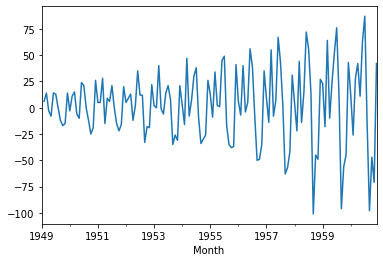

In [9]:
df_diff = df["Passengers"].diff(periods=1)
df_diff.plot()

#### 対数変換データ

In [10]:
df_log = np.log(df["Passengers"])
df_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
Name: Passengers, dtype: float64

<AxesSubplot:xlabel='Month'>

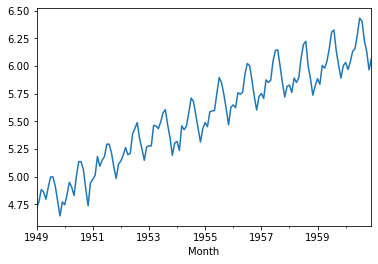

In [11]:
df_log.plot()

#### 対数差分系列変換データ

<AxesSubplot:xlabel='Month'>

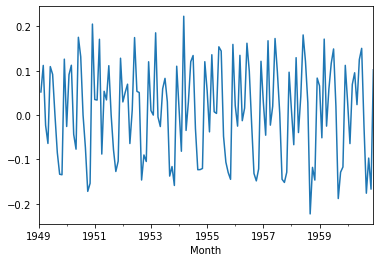

In [12]:
df_log_diff = df_log.diff(periods=1)
df_log_diff.plot()

#### 差分系列＋季節調整済みデータ（=前年差）

<AxesSubplot:xlabel='Month'>

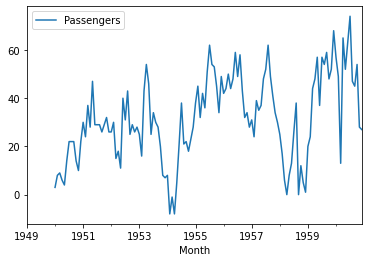

In [13]:
# 周期性：periods = 12として季節差分
df_sdiff = df.diff(periods=12)
df_sdiff.plot()

#### 前年差の差分系列

<AxesSubplot:xlabel='Month'>

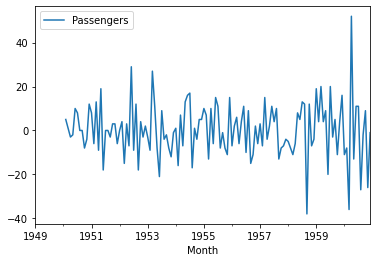

In [14]:
df_sdiff2 = df_sdiff.diff()
df_sdiff2.plot()

#### 定常性の確認

* [adfuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) を用いて、Dickey-Fuller 検定を行う
* df_sdiff2: p-value < 0.1 なので有意水準10%で帰無仮説が棄却され、定常を満たす

In [15]:
# NaNを削除
df_sdiff2 = df_sdiff2.dropna(how="all")

res = sm.tsa.stattools.adfuller(df_sdiff2.Passengers)
print("p-value = {:.4}".format(res[1]))

p-value = 1.857e-28


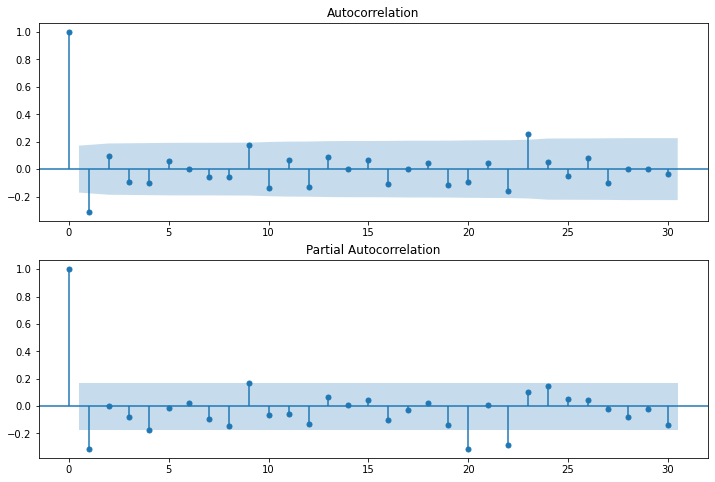

In [16]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_sdiff2.Passengers, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_sdiff2.Passengers, lags=30, ax=ax2)

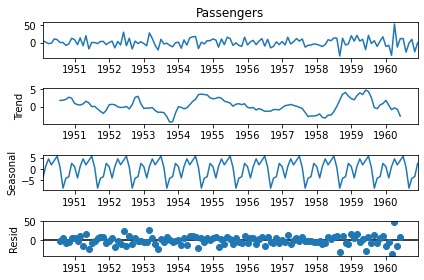

In [17]:
res = sm.tsa.seasonal_decompose(df_sdiff2["Passengers"])
fig = res.plot()

## SARIMA構築

In [18]:
# 学習と評価データに分割
df_train = df[df.index < "1957-04-01"]
df_test = df[df.index >= "1957-04-01"]

In [19]:
ts = df.Passengers
ts_train = df_train.Passengers
ts_test = df_test.Passengers

#### arma_order_select_ic
- [arma_order_select_ic](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.arma_order_select_ic.html) を用いて、パラメータを決定
- AIC min: p=4, q=3

In [20]:
warnings.filterwarnings("ignore")

df_sdiff2_train = df_sdiff2[df_sdiff2.index < "1957-04-01"]
res = sm.tsa.arma_order_select_ic(df_sdiff2_train, max_ar=7, max_ma=7, ic="aic")
res.aic_min_order

(4, 3)

In [21]:
def eval_model(ts_train, ts_test, result):
    train_pred = result.predict()
    test_pred = result.forecast(len(ts_test))
    test_pred_ci = result.get_forecast(len(ts_test)).conf_int()

    train_rmse = np.sqrt(mean_squared_error(ts_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(ts_test, test_pred))
    print("RMSE(train):\t{:.5}\nRMSE(test):\t{:.5}".format(train_rmse, test_rmse))
    return train_pred, test_pred, test_pred_ci

In [22]:
order = (4, 1, 3)
seasonal_order = (1, 1, 1, 12)
model = SARIMAX(
    ts_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
result = model.fit()
train_pred, test_pred, test_pred_ci = eval_model(ts_train, ts_test, result)
result.summary()

RMSE(train):	17.926
RMSE(test):	27.294


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           Passengers   No. Observations:                   99
Model:             SARIMAX(4, 1, 3)x(1, 1, [1], 12)   Log Likelihood                -256.953
Date:                              Sat, 24 Jul 2021   AIC                            533.907
Time:                                      06:36:06   BIC                            556.391
Sample:                                  01-01-1949   HQIC                           542.838
                                       - 03-01-1957                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9957      1.551      0.642      0.521      -2.045       4.036
ar.L2         -0.6726      1.697     -0.396      0.692      -3.998       2.653
ar.L3          0.2348      0.891      0.263      0.792      -1.512       1.981
ar.L4          0.0550      0.224      0.246      0.806      -0.383       0.493
ma.L1         -1.2377      1.546     -0.800      0.424      -4.269       1.793
ma.L2          0.8414      1.942      0.433      0.665      -2.964       4.647
ma.L3         -0.4885      1.030     -0.474      0.635      -2.508       1.531
ar.S.L12      -0.0037      0.121     -0.031      0.975      -0.240       0.233
ma.S.L12      -0.2604      0.192     -1.355      0.175      -0.637       0.116
sigma2        87.8444     17.057      5.150      0.000      54.414     121.275
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.86
Prob(Q):                              0.90   Prob(JB):                         0.39
Heteroskedasticity (H):               1.10   Skew:                             0.40
Prob(H) (two-sided):                  0.82   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
train_pred = result.predict()
test_pred = result.forecast(len(ts_test))

In [24]:
test_pred_ci = result.get_forecast(len(ts_test)).conf_int()
print(test_pred_ci)

            lower Passengers  upper Passengers
1957-04-01        332.675546        369.415212
1957-05-01        333.200583        379.302924
1957-06-01        381.247899        433.788248
1957-07-01        419.242289        475.188337
1957-08-01        408.416980        466.335158
1957-09-01        361.841250        421.352274
1957-10-01        315.784465        376.846030
1957-11-01        280.192156        342.669677
1957-12-01        314.899816        378.565522
1958-01-01        322.831545        387.526003
1958-02-01        310.051346        375.725168
1958-03-01        360.396683        427.045461
1958-04-01        350.811274        427.705634
1958-05-01        352.585828        435.735074
1958-06-01        401.459777        489.705079
1958-07-01        439.630725        531.383350
1958-08-01        428.586401        522.946554
1958-09-01        381.582350        478.265258
1958-10-01        335.108670        434.053037
1958-11-01        299.173863        400.256098
1958-12-01   

In [25]:
train_rmse = np.sqrt(mean_squared_error(df_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(df_test, test_pred))
print("RMSE(train): {:.5}\nRMSE(test): {:.5}".format(train_rmse, test_rmse))

RMSE(train): 17.926
RMSE(test): 27.294


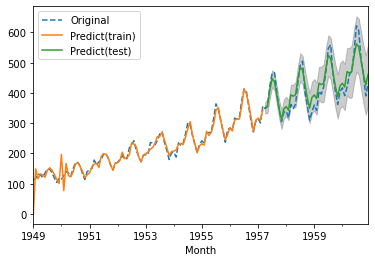

In [26]:
fig, ax = plt.subplots()
df.Passengers.plot(ax=ax, label="Original", linestyle="dashed")
train_pred.plot(ax=ax, label="Predict(train)")
test_pred.plot(ax=ax, label="Predict(test)")
ax.fill_between(
    test_pred_ci.index,
    test_pred_ci.iloc[:, 0],
    test_pred_ci.iloc[:, 1],
    color="k",
    alpha=0.2,
)
ax.legend()